In [1]:
# Import Libraries
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import json
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers
from sklearn.preprocessing import MinMaxScaler
from datetime import datetime, timedelta
from copy import deepcopy
import math

2024-07-22 23:49:48.739469: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-07-22 23:49:48.772764: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-07-22 23:49:48.828034: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-22 23:49:48.865151: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-22 23:49:48.873626: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-22 23:49:48.940602: I tensorflow/core/platform/cpu_feature_gu

In [2]:

with open('../stock_scraper/companies_data/AB.json') as f:
    data = json.load(f)

amen_bank = pd.json_normalize(data, 'QuoteTab', ['Name'])

# Rename the columns
amen_bank.rename(columns={
    'Name': 'companyName',
    'd': 'date',
    'o': 'openingPrice',
    'h': 'highestPrice',
    'l': 'lowestPrice',
    'c': 'closingPrice',
    'v': 'volume'
}, inplace=True)
amen_bank

,date,openingPrice,highestPrice,lowestPrice,closingPrice,volume,companyName
0,16/06/2014,22.75,23.10,22.49,22.75,425,AMEN BANK
1,23/06/2014,22.75,22.93,22.07,22.65,1899,AMEN BANK
2,30/06/2014,22.65,22.66,22.23,22.65,2066,AMEN BANK
3,07/07/2014,22.65,22.75,22.31,22.75,3054,AMEN BANK
4,14/07/2014,22.75,22.75,22.49,22.49,1503,AMEN BANK
...,...,...,...,...,...,...,...
517,13/05/2024,44.97,46.50,43.00,43.99,33870,AMEN BANK
518,20/05/2024,43.99,43.99,42.20,43.20,8729,AMEN BANK
519,27/05/2024,43.20,44.00,43.10,44.00,6378,AMEN BANK
520,03/06/2024,44.00,44.00,43.35,43.99,13312,AMEN BANK


In [3]:
print(amen_bank.shape)


(522, 7)


In [4]:
amen_bank=amen_bank.reset_index()['closingPrice']
amen_bank

0      22.75
1      22.65
2      22.65
3      22.75
4      22.49
       ...  
517    43.99
518    43.20
519    44.00
520    43.99
521    43.90
Name: closingPrice, Length: 522, dtype: float64

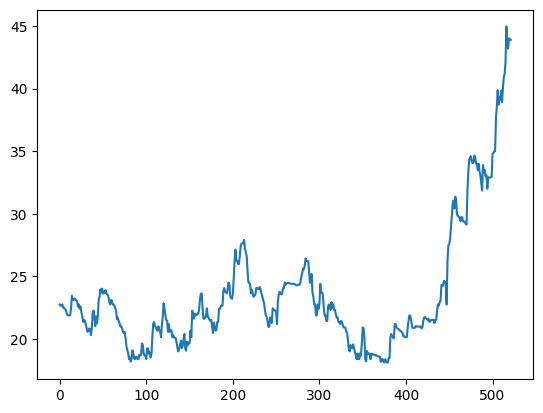

In [5]:
plt.plot(amen_bank)

In [6]:
scaler=MinMaxScaler(feature_range=(0,1))
scaled_data=scaler.fit_transform(np.array(amen_bank).reshape(-1,1))
scaled_data

array([[0.17274758],
       [0.16902457],
       [0.16902457],
       [0.17274758],
       [0.16306776],
       [0.16269546],
       [0.15934475],
       [0.15599404],
       [0.14668652],
       [0.14035741],
       [0.14035741],
       [0.14035741],
       [0.14035741],
       [0.15971705],
       [0.19843634],
       [0.18726731],
       [0.18577811],
       [0.19061802],
       [0.18912882],
       [0.18428891],
       [0.1824274 ],
       [0.16641847],
       [0.17274758],
       [0.15971705],
       [0.16641847],
       [0.14929263],
       [0.1370067 ],
       [0.12062547],
       [0.12732688],
       [0.12397617],
       [0.11429635],
       [0.10275503],
       [0.0912137 ],
       [0.09456441],
       [0.10126582],
       [0.09791512],
       [0.08116158],
       [0.10126582],
       [0.14668652],
       [0.15450484],
       [0.1377513 ],
       [0.10796724],
       [0.1370067 ],
       [0.11727476],
       [0.14035741],
       [0.18912882],
       [0.19545793],
       [0.217

In [7]:
##splitting dataset into train and test split
training_size=int(len(scaled_data)*0.65)
test_size=len(scaled_data)-training_size
train_data,test_data=scaled_data[0:training_size,:],scaled_data[training_size:len(scaled_data),:1]

In [8]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]  
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return np.array(dataX), np.array(dataY)

In [9]:

time_step = 10
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

In [10]:
print(X_train.shape), print(y_train.shape)

(328, 10)
(328,)


(None, None)

In [11]:
print(X_test.shape), print(y_test.shape)

(172, 10)
(172,)


(None, None)

In [12]:
# reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [13]:
model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(10,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

/home/firas/.local/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [14]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 10, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 10, 50)         │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 50,851 (198.64 KB)

 Trainable params: 50,851 (198.64 KB)

 Non-trainable params: 0 (0.00 B)

In [15]:
model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 106ms/step - loss: 0.0264 - val_loss: 0.0885
Epoch 2/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0055 - val_loss: 0.0383
Epoch 3/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0059 - val_loss: 0.0606
Epoch 4/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0044 - val_loss: 0.0594
Epoch 5/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0038 - val_loss: 0.0390
Epoch 6/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0032 - val_loss: 0.0283
Epoch 7/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0027 - val_loss: 0.0233
Epoch 8/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0023 - val_loss: 0.0123
Epoch 9/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0019 - val_loss: 0.0059
Epoch 10/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0019 - val_loss: 0.0062
Epoch 11/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0020 - val_loss: 0.0052
Epoch 12/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0020 - val_l

In [16]:
### Do the prediction and check performance metrics
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


In [17]:
##Transformback to original form
train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)

In [18]:
math.sqrt(mean_squared_error(y_train,train_predict))

22.145631302504206

In [19]:
### Test Data RMSE
math.sqrt(mean_squared_error(y_test,test_predict))

25.904759605135876

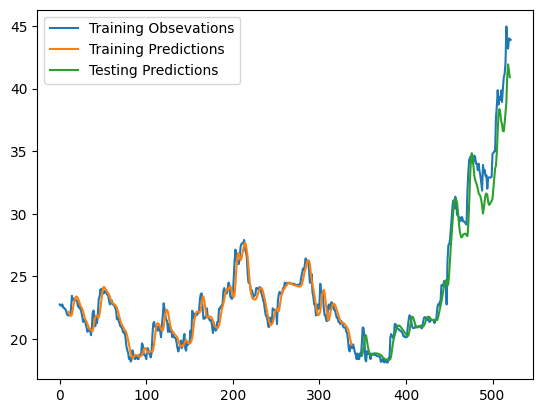

In [20]:
### Plotting 
#  train predictions for plotting
look_back=10
trainPredictPlot = np.empty_like(scaled_data)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
# test predictions for plotting
testPredictPlot = np.empty_like(scaled_data)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(scaled_data)-1, :] = test_predict

plt.plot(scaler.inverse_transform(scaled_data))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.legend(['Training Obsevations', 
                    'Training Predictions',
                    'Testing Predictions', 
                    ])
plt.show()

In [21]:
len(test_data)

183

In [22]:
x_input=test_data[84:].reshape(1,-1)
x_input.shape

(1, 99)

In [23]:
temp_input=list(x_input)
temp_input=temp_input[0].tolist()

In [24]:
temp_input

[0.1314221891288161,
 0.13030528667163066,
 0.12658227848101267,
 0.13030528667163066,
 0.12062546537602381,
 0.12211466865227105,
 0.12658227848101267,
 0.12658227848101267,
 0.12658227848101267,
 0.12695457930007437,
 0.11727475800446763,
 0.12546537602382724,
 0.127699180938198,
 0.15636634400595673,
 0.17274758004467605,
 0.16939687267311987,
 0.17944899478778853,
 0.18428890543559184,
 0.23045420699925534,
 0.2293373045420699,
 0.2285927029039464,
 0.24274013402829475,
 0.23790022338049144,
 0.23790022338049144,
 0.17274758004467605,
 0.3030528667163067,
 0.3488458674609083,
 0.35182427401340277,
 0.368205510052122,
 0.40096798212956064,
 0.43633655994043186,
 0.47207743857036477,
 0.4821295606850333,
 0.4579300074460164,
 0.4932985852568874,
 0.4817572598659716,
 0.44005956813104974,
 0.43670886075949356,
 0.43261355174981375,
 0.43186895011169013,
 0.42032762472077434,
 0.43186895011169013,
 0.43261355174981375,
 0.42032762472077434,
 0.41995532390171264,
 0.41697691734921816,
 

In [25]:
# demonstrate prediction for next 10 days

lst_output=[]
n_steps=100
i=0
while(i<30):
    
    # Before entering the loop, ensure temp_input has exactly n_steps elements
    if len(temp_input) < n_steps:
        print(f"temp_input has only {len(temp_input)} elements, which is less than the required {n_steps} elements.")
        # Handle this scenario, e.g., by appending dummy data or skipping the prediction
        # For example, to append zeros: temp_input.extend([0] * (n_steps - len(temp_input)))
        # Skipping the prediction in this case:
        continue  # Or use another approach as needed
    
    # Now inside the loop, temp_input is guaranteed to have at least n_steps elements
    if(len(temp_input) >= n_steps):
        x_input=np.array(temp_input[-n_steps:])  # Ensure x_input is constructed from the last n_steps elements
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
    
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
    
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        # Handle the case where temp_input does not have enough elements after the first iteration
        pass  # Implement your logic here
    

print(lst_output)

ValueError: cannot reshape array of size 99 into shape (1,100,1)

In [ ]:
day_new=np.arange(1,101)
day_pred=np.arange(101,131)

In [ ]:
len(scaled_data)

523

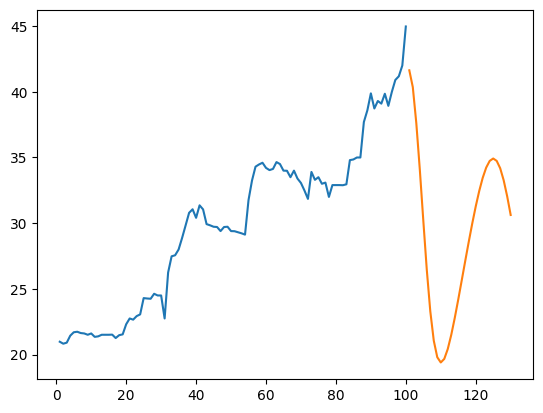

In [ ]:
plt.plot(day_new,scaler.inverse_transform(scaled_data[423:]))
plt.plot(day_pred,scaler.inverse_transform(lst_output))

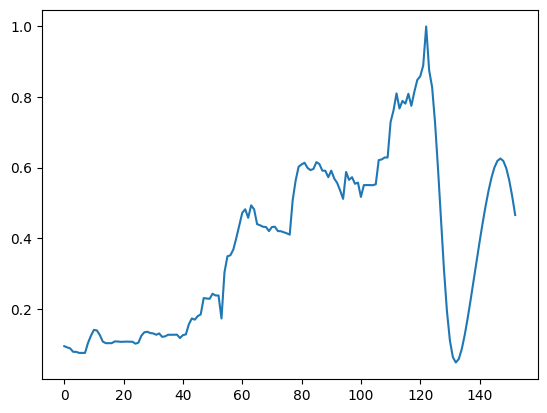

In [ ]:
stock_pred=scaled_data.tolist()
stock_pred.extend(lst_output)
plt.plot(stock_pred[400:])

In [ ]:
stock_pred=scaler.inverse_transform(stock_pred).tolist()

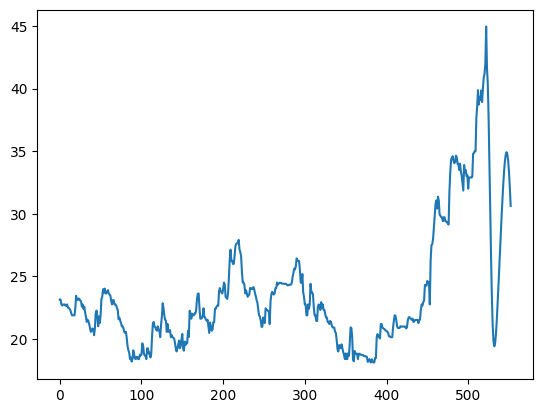

In [ ]:
plt.plot(stock_pred)